# Backbone notebook

Inspired by: http://nbviewer.jupyter.org/github/ademyanchuk/protein_atlas_baseline/blob/master/protein-1.ipynb



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [5]:
# from fastai.utils.collect_env import *
# show_install(0)

In [4]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('../tests/')
from challenge_setup import *


In [5]:
#open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

In [6]:
np.random.seed(42)
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [7]:
bs = 64
sz = 64

In [8]:
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train.csv', sep=' ', folder='train_combined', suffix='.png')  
       .random_split_by_pct(0.2))

In [9]:
# start with smaller size
data = (src.datasets()
        .transform(tfms, size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
#data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
    
def f1(y_pred, y_true, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True):
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=0)
    prec = TP/(y_pred.sum(dim=0)+eps)
    rec = TP/(y_true.sum(dim=0)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(0)
    prec = TP/(y_pred.sum(0)+1e-7)
    rec = TP/(y_true.sum(0)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)


# def f1(y_pred, y_true, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True):
#     beta2 = beta**2
#     if sigmoid: y_pred = y_pred.sigmoid()
#     y_pred = (y_pred>thresh).float()
#     y_true = y_true.float()
#     TP = (y_pred*y_true).sum(dim=0)
#     prec = TP/(y_pred.sum(dim=0)+eps)
#     rec = TP/(y_true.sum(dim=0)+eps)
#     res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
#     return res.mean()
# def f1_(preds, targs, start=0.17, end=0.24, step=0.01):
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         return max([fbeta_score(targs, (preds>th), 1, average='samples')
#                     for th in np.arange(start,end,step)])

## Resnet 18 + 64

In [12]:
arch = models.resnet18

In [31]:
f1_score = partial(fbeta, thresh=0.2, beta=1.)
learn = create_cnn(data, arch,  metrics=[accuracy_thresh, f1 , f1_score]).to_fp16()


#learn = create_cnn(data, arch, metrics=[accuracy_thresh]).to_fp16()
#learn = create_cnn(data, arch).to_fp16()

learn.crit = FocalLoss()

In [32]:
#learn.data.valid_dl.add_tfm(to_half)
#learn.data.valid_dl.add_tfm(to_half)
#learn.model.float()
#learn.show_results()

## Save model after each epoch

In [33]:
# add save SaveModelCallback to save the model weights for every epoch
# learn.callback_fns.append(partial(SaveModelCallback, every='epoch', name='lung_inf_v4-ResNet34_stage-X_train-Y_epoch'))

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


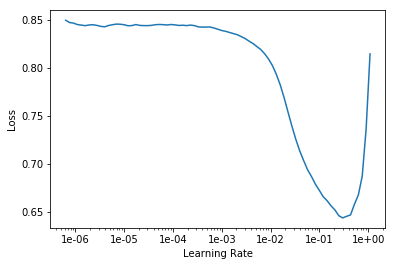

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
lr = 3e-2
learn.fit_one_cycle(5, slice(lr))

Total time: 04:47
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.165833    0.159638    0.947044         0.039302  0.382510  (00:57)
2      0.168544    0.169528    0.946377         0.034862  0.353125  (00:57)
3      0.160883    0.159876    0.947773         0.052879  0.392942  (00:57)
4      0.154199    0.152152    0.948877         0.055448  0.412195  (00:57)
5      0.150509    0.156271    0.949555         0.061921  0.420337  (00:57)



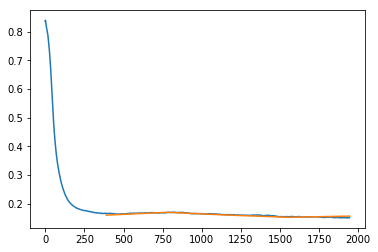

In [36]:
learn.recorder.plot_losses()

In [37]:
learn.save('stage-1-rn18-64')

## Unfreeze to train pretrained weights a bit

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


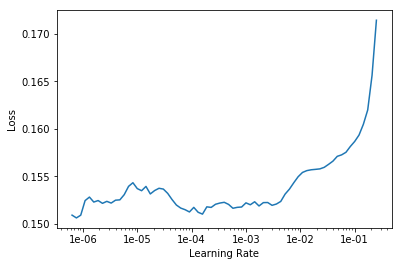

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 04:47
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.152430    0.149749    0.949647         0.062075  0.422661  (00:57)
2      0.152083    0.152298    0.949659         0.064231  0.422540  (00:57)
3      0.150726    0.153076    0.949727         0.063703  0.423607  (00:57)
4      0.150806    0.158689    0.949572         0.064111  0.422621  (00:57)
5      0.149977    0.155792    0.949693         0.064675  0.422750  (00:57)



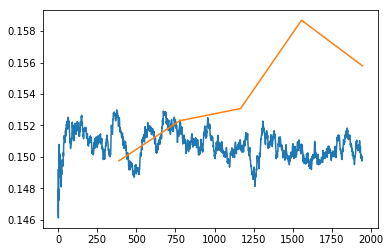

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('stage-2-rn18-64')

## Resnet18 + 128

In [42]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/home/fabsta/projects/deeplearning/fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 128, 128])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


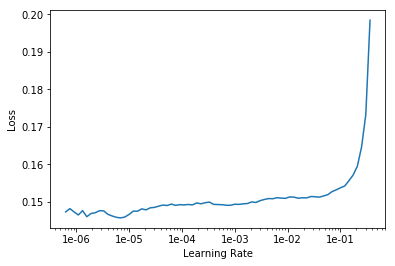

In [43]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [44]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn18-128')

Total time: 05:13
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.148622    0.145822    0.950492         0.074878  0.443987  (01:03)
2      0.146950    0.148567    0.950728         0.076791  0.453697  (01:02)
3      0.146043    0.140951    0.951458         0.089806  0.471535  (01:02)
4      0.142561    0.158220    0.951009         0.091996  0.470107  (01:02)
5      0.141926    0.142987    0.951877         0.089040  0.477390  (01:02)



Total time: 05:15
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.142403    0.143496    0.951676         0.091963  0.478380  (01:03)
2      0.142948    0.162741    0.952159         0.103510  0.479726  (01:03)
3      0.140310    0.155969    0.951940         0.108587  0.489906  (01:03)
4      0.137972    0.161943    0.952659         0.114906  0.497051  (01:02)
5      0.136478    0.184216    0.952636         0.118561  0.498040  (01:02)



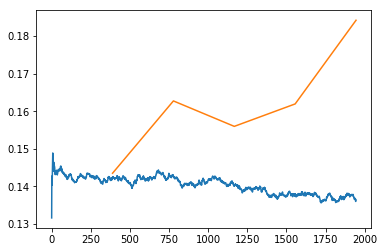

In [45]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))
learn.recorder.plot_losses()

In [46]:
learn.save('stage-2-rn18-128')

## Resnet18 + 256 

In [47]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


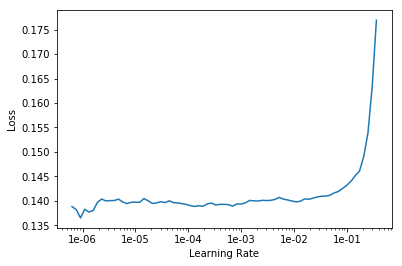

In [48]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [49]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn18-256')

Total time: 07:08
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.135324    0.164844    0.953797         0.124395  0.518370  (01:25)
2      0.132857    0.146596    0.955211         0.150903  0.536574  (01:26)
3      0.129558    0.179956    0.955826         0.171289  0.544745  (01:25)
4      0.127905    0.221857    0.956360         0.172506  0.557861  (01:25)
5      0.123336    0.184795    0.956711         0.180051  0.557248  (01:25)



In [50]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 07:39
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.125212    0.144313    0.955670         0.184352  0.549372  (01:32)
2      0.126665    0.123618    0.958107         0.200550  0.565314  (01:31)
3      0.120619    0.124607    0.956849         0.197077  0.558923  (01:31)
4      0.117846    0.114711    0.960153         0.229768  0.594259  (01:31)
5      0.116584    0.112467    0.960280         0.231946  0.598594  (01:31)



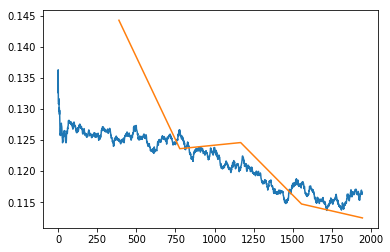

In [51]:
learn.recorder.plot_losses()
learn.save('stage-2-rn18-256')

## Resnet18 + 512

In [52]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=512)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 512, 512])

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


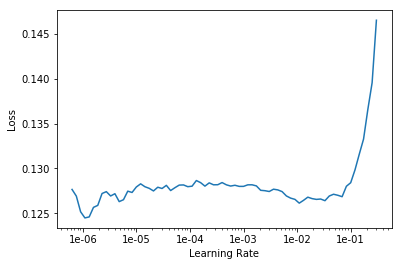

In [53]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [54]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))
learn.save('stage-1-rn18-512')

Total time: 20:07
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.117218    0.124044    0.957711         0.199633  0.571791  (04:03)
2      0.112762    0.121003    0.960211         0.230443  0.602541  (04:00)
3      0.109424    0.124934    0.960464         0.249303  0.621616  (04:01)
4      0.106045    0.124522    0.961803         0.259755  0.630137  (04:00)
5      0.104669    0.108248    0.962303         0.271550  0.633263  (04:01)



In [55]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 25:19
epoch  train_loss  valid_loss  accuracy_thresh  f1  fbeta         
1      0.106126    0.110983    0.961688         0.275720  0.620819  (05:04)
2      0.103221    0.145842    0.961849         0.282868  0.637381  (05:03)
3      0.099622    0.106237    0.963412         0.298535  0.646055  (05:03)
4      0.096207    0.107456    0.965246         0.311778  0.668999  (05:03)
5      0.094181    0.099253    0.965699         0.321625  0.672100  (05:03)



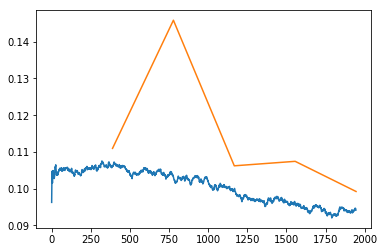

In [56]:
learn.recorder.plot_losses()
learn.save('stage-2-rn18-512')

## Predictions

In [ ]:
p_v, t_v = learn.get_preds(DatasetType.Valid)

In [23]:
# find optimal weight decay parameter
# from https://github.com/DrHB/fastai_wd/blob/master/wd_example.ipynb

@dataclass  
class wd_finder:
    #learner
    #wd, can be a single value or a tuple
    # if no wd is passed it will use standard wds 
    
    learn: Learner
    wd:Union[int,Callable]=None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0, 1e-1, 1e-3, 1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd, **kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='wd = {}'.format(self.wd_list[k]))
            ax.legend()
            ax.set_xscale('log')